## A detour – to DL machinery with pytorch

## Goal:
* Get familiar with a basic pytorch neural network

## Steps:
1. Define Network, loss & optimizer
2. Get Dataset - MNIST
3. Construct minibatch dataloader
4. Forward pass
5. Calculate error/loss
6. Do backprop
7. Update weights using Gradient Descent
8. Train & Test

### Reference : 
* pytorch Udacity git https://github.com/udacity/deep-learning-v2-pytorch

### 1. Install the required packages

* No esoteric requirements
* You can run them without docker
* pip install -r requirements.txt
* Requirements
 * python 3.6, pytorch, openAI gym, numpy, matplotlib
 * anaconda is easier but not needed
 * Miniconda works fine

### 2. Define imports

python 3, numpy, matplotlib, torch, gym

In [1]:
# General imports
import gym
import PIL # for in-line display of certain environments

import sys
import numpy as np
import random
from collections import namedtuple, deque, defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### 2.1. Global Constants and other variables

In [2]:
# Constants Definitions
BUFFER_SIZE = 512 # int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
# Number of neurons in the layers of the Network
FC1_UNITS = 128
FC2_UNITS = 64
FC3_UNITS = 32
# Store models flag. Store during calibration runs and do not store during hyperparameter search
STORE_MODELS = False

### 3. pytorch DL machinery 

### 3.1. Define Network

In [3]:
class ANetwork(nn.Module):
    def __init__(self, input_size, output_size, seed=42, fc1_units = FC1_UNITS, fc2_units = FC2_UNITS, 
                 fc3_units = FC3_UNITS):
        """Initialize parameters and build model."""
        super(ANetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        # self.fc3 = nn.Linear(fc2_units,fc3_units)
        # self.fc4 = nn.Linear(fc3_units,action_size)
        self.fc4 = nn.Linear(fc2_units,output_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x),dim=-1)
        return x

### 3.2 Get MNIST Dataset

In [4]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)

### 3.3 Construct minibatch dataloader

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

### 3.4 Create network instance & loss 
### And a quick functional test

In [6]:
model = ANetwork(784,10)
# Define the loss
criterion = nn.CrossEntropyLoss()

In [7]:
model

ANetwork(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

### 3.4 Forward pass

In [8]:
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)

### 3.5 Calculate error/loss

In [9]:
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3000, grad_fn=<NllLossBackward>)


### 3.6 Do backprop

In [10]:
print('Before backward pass: \n', model.fc1.weight.grad)

loss.backward()

print('After backward pass: \n', model.fc1.weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-1.9411e-04, -1.9411e-04, -1.9411e-04,  ..., -1.9411e-04,
         -1.9411e-04, -1.9411e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.1654e-04,  3.1654e-04,  3.1654e-04,  ...,  3.1654e-04,
          3.1654e-04,  3.1654e-04],
        ...,
        [ 1.4630e-04,  1.4630e-04,  1.4630e-04,  ...,  1.4630e-04,
          1.4630e-04,  1.4630e-04],
        [-8.2381e-05, -8.2381e-05, -8.2381e-05,  ..., -8.2381e-05,
         -8.2381e-05, -8.2381e-05],
        [ 2.4894e-04,  2.4894e-04,  2.4894e-04,  ...,  2.4894e-04,
          2.4894e-04,  2.4894e-04]])


### Create Optimizer

In [11]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

### 3.7 Update weights using Gradient Descent

In [12]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
        [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
        [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0058],
        ...,
        [-0.0195,  0.0034,  0.0302,  ..., -0.0030, -0.0317,  0.0128],
        [-0.0107,  0.0221, -0.0158,  ..., -0.0121,  0.0042,  0.0318],
        [-0.0106,  0.0342,  0.0240,  ...,  0.0091,  0.0174,  0.0041]],
       requires_grad=True)


## Train
### Now let us do full training

In [13]:
import time
from datetime import datetime, timedelta

start_time = time.time()

# This is another way (probably easier) of building a network in pytorch
# Instead of softmax, it uses log softmax

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Training loss: {running_loss/len(trainloader)}")
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))

Training loss: 1.9054298902879645
Training loss: 0.8417148233603821
Training loss: 0.5145313322925364
Training loss: 0.42803383418428365
Training loss: 0.3852721249370941
Elapsed : 0:00:40.669939


### 4. Test
#### I like the Udacity helper class - very good to test the MNIST results

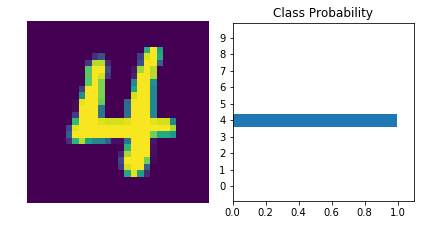

In [14]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

### Calculate Accuracy
#### For this we need to load the test dataset, run the forward pass and then calculate the accuracy

In [26]:
# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [35]:
images, labels = next(iter(testloader))
print(images.shape,labels.shape)

img = images = images.view(images.shape[0], -1)
# Get the class probabilities
ps = torch.exp(model(img))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 10])


In [36]:
top_p, top_class = ps.topk(1, dim=1)
print(top_class.shape)
print(top_p.shape)

torch.Size([64, 1])
torch.Size([64, 1])


In [33]:
equals = top_class == labels.view(*top_class.shape) # pay attention to shapes and sizes

In [37]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 85.9375%


## _That's all Folks !_